In [1]:
# # Mount Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import tensorflow as tf
print(tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [3]:
import os
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image

In [4]:
# Define location of the images and labels
xbd_dir="C:\\Users\\PC\\Desktop\\damage_assessement_data\\fusion_aug"
images_dir=os.path.join(xbd_dir,"images")
labels_dir=os.path.join(xbd_dir,"labels")
masks_dir = os.path.join(xbd_dir, 'masks')
train_data_info="C:\\Users\\PC\\Desktop\\damage_assessement_data\\fusion_aug\\train_data_info.csv"
#extracted_files="C:\\Users\\PC\\Desktop\\drac_saved_files"

train_batch_size = 32
test_batch_size = 16
epochs = 100
frequency = 25
log_dir = os.path.join(xbd_dir,"logs")


In [5]:

# Read mask and convert to array
def read_mask_image(path, dtype):
    with Image.open(path) as img:
        img = img.convert('1')
        image = np.array(img, dtype=dtype)
    return image

# Read image and convert to array
def read_disaster_image(path, dtype):
    with Image.open(path) as img:
        image = np.array(img, dtype=dtype)
    return image


In [6]:
# Define a custom data generator
import cv2
class CustomDataset(tf.keras.utils.Sequence):
    def __init__(self, data_path, images_path, masks_path, mean, crop_size=400, batch_size=32, is_test=False):
        with open(data_path) as file:
            self.image_mask_pairs = [line.rstrip('\n') for line in file]
        self.images_path = images_path
        self.masks_path = masks_path
        self.mean = mean
        self.crop_size = crop_size
        self.batch_size = batch_size
        self.is_test = is_test

    def __len__(self):
        return len(self.image_mask_pairs) // self.batch_size



    def __getitem__(self, index):
        batch_pairs = self.image_mask_pairs[index * self.batch_size:(index + 1) * self.batch_size]
        images, masks = [], []
        for pair in batch_pairs:
            image_filename = label_filename = pair
            image = read_disaster_image(os.path.join(self.images_path, image_filename), np.float32)
            image = (image - self.mean) / 255.0
            mask_image = read_mask_image(os.path.join(self.masks_path, label_filename), np.int32)
            #print(f'image file name:{image_filename}, mask file name: {label_filename}')
            #print(f"Original Image shape: {image.shape}, Original Mask shape: {mask_image.shape}")
            h, w, c = image.shape
            mask = np.zeros(shape=[h, w], dtype=np.int32)
            mask[mask_image > 0] = 1

            # Resize the mask to match the output shape
            #mask = resize_mask(mask, output_shape=(400, 400))

            # print('mask shape =', mask.shape)
            # print('image shape=',image.shape)


            if (h < self.crop_size) or (w < self.crop_size):
                H, W = max(h, self.crop_size), max(w, self.crop_size)
                padding_x1, padding_y1 = (W - w) // 2, (H - h) // 2
                padding_x2, padding_y2 = (W - w - padding_x1), (H - h - padding_y1)
                image = np.pad(image, ((padding_y1, padding_y2), (padding_x1, padding_x2), (0, 0)), 'symmetric')
                if self.is_test:
                    mask = np.pad(mask, ((padding_y1, padding_y2), (padding_x1, padding_x2)), 'constant', constant_values=255)
                else:
                    mask = np.pad(mask, ((padding_y1, padding_y2), (padding_x1, padding_x2)), 'symmetric')

            if not self.is_test:
                if random.choice([True, False]):
                    image = image[:, ::-1, :]
                    mask = mask[:, ::-1]
                if random.choice([True, False]):
                    image = image[::-1, :, :]
                    mask = mask[::-1, :]

                top = random.randint(0, h - self.crop_size)
                left = random.randint(0, w - self.crop_size)
            else:
                top = (h - self.crop_size) // 2
                left = (w - self.crop_size) // 2

            bottom = top + self.crop_size
            right = left + self.crop_size
            image = image[top:bottom, left:right]
            mask = mask[top:bottom, left:right]

            #resizing the mask
            # Resize masks to match the output size of the model
            image = tf.image.resize(image, [self.crop_size, self.crop_size]).numpy()
            mask = tf.image.resize(mask[..., np.newaxis], [self.crop_size, self.crop_size], method='nearest').numpy().squeeze()
            #print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")  # Debug print statement


            images.append(image)
            masks.append(mask)

        return np.array(images), np.array(masks)

def resize_mask(mask, output_shape):
      return cv2.resize(mask, output_shape, interpolation=cv2.INTER_NEAREST)

In [7]:
from tensorflow.keras import layers
from tensorflow import keras

def UNet(input_shape=(200,200,3)):
  inputs = keras.Input(shape=input_shape)

  #encoding path
  c0 = layers.Conv2D(32,(3,3),padding='same',activation='relu')(inputs)  #3x3 kernel size
  c0=layers.BatchNormalization()(c0)
  #print('c0 shape=',c0.shape)

  c1=layers.Conv2D(64,(4,4),strides=2,padding='same',activation='relu')(c0)
  c1=layers.BatchNormalization()(c1)
  #print('c1 shape=',c1.shape)

  c2=layers.Conv2D(64,(3,3),padding='same',activation='relu')(c1)
  c2=layers.BatchNormalization()(c2)
  #print('c2 shape=',c2.shape)

  c3=layers.Conv2D(128,(4,4),strides=2,padding='same',activation='relu')(c2)
  c3=layers.BatchNormalization()(c3)
  #print('c3 shape=',c3.shape)

  c4=layers.Conv2D(128,(3,3),padding='same',activation='relu')(c3)
  c4=layers.BatchNormalization()(c4)
  #print('c4 shape=',c4.shape)

  c5=layers.Conv2D(256,(4,4),strides=2,padding='same',activation='relu')(c4)
  c5=layers.BatchNormalization()(c5)
  #print('c5 shape=',c5.shape)

  c6=layers.Conv2D(256,(3,3),padding='same',activation='relu')(c5)
  c6=layers.BatchNormalization()(c6)
  #print('c6 shape=',c6.shape)

  c7=layers.Conv2D(512,(4,4),strides=2,padding='same',activation='relu')(c6)
  c7=layers.BatchNormalization()(c7)
  #print('c7 shape=',c7.shape)

  c8=layers.Conv2D(512,(3,3),padding='same',activation='relu')(c7)
  c8=layers.BatchNormalization()(c8)
  #print('c8 shape=',c8.shape)

  #decoding network

  # u8=layers.Conv2DTranspose(512,(4,4),strides=2,padding='same',activation='relu')(c8)
  # u8=layers.BatchNormalization()(u8)
  # print('u8 shape before concatination=',u8.shape)
  # c8_upsampled = layers.Conv2DTranspose(512, 4, strides=2, padding='same', activation='relu')(c8)
  # print('c8_upsampled shape=',c8_upsampled.shape)
  # u8=layers.concatenate([u8,c8_upsampled])
  # print('u8 shape after concatination=',u8.shape)

  u7=layers.Conv2DTranspose(512,(4,4),strides=1,padding='same',activation='relu')(c8)
  u7=layers.BatchNormalization()(u7)
  #print('u7 shape before concatination=',u7.shape)
  #c7_upsampled = layers.Conv2DTranspose(512, 4, strides=2, padding='same', activation='relu')(c7)
  #print('c7_upsampled shape=',c7_upsampled.shape)
  u7=layers.concatenate([u7,c7])
  #print('u7 shape after concatination=',u7.shape)

  u6=layers.Conv2DTranspose(256,(4,4),strides=2,padding='same',activation='relu')(u7)
  u6=layers.BatchNormalization()(u6)
  #print('u6 shape before concatination=',u6.shape)
  #c6_upsampled = layers.Conv2DTranspose(256, 4, strides=2, padding='same', activation='relu')(c6)
  #print('c6_upsampled shape=',c6_upsampled.shape)
  u6=layers.concatenate([u6,c6])
  #print('u6 shape after concatination=',u6.shape)

  u5=layers.Conv2DTranspose(256,(4,4),strides=1,padding='same',activation='relu')(u6)
  u5=layers.BatchNormalization()(u5)
  #print('u5 shape before concatination=',u5.shape)
  #c5_upsampled = layers.Conv2DTranspose(256, 4, strides=2, padding='same', activation='relu')(c5)
  #print('c5_upsampled shape=',c5_upsampled.shape)
  u5=layers.concatenate([u5,c5])
  #print('u5 shape after concatination=',u5.shape)

  u4=layers.Conv2DTranspose(128,(4,4),strides=2,padding='same',activation='relu')(u5)
  u4=layers.BatchNormalization()(u4)
  #print('u4 shape before concatination=',u4.shape)
  #c4_upsampled = layers.Conv2DTranspose(128, 4, strides=2, padding='same', activation='relu')(c4)
  #print('c4_upsampled shape=',c4_upsampled.shape)
  u4=layers.concatenate([u4,c4])
  #print('u4 shape after concatination=',u4.shape)

  u3=layers.Conv2DTranspose(128,(4,4),strides=1,padding='same',activation='relu')(u4)
  u3=layers.BatchNormalization()(u3)
  #print('u3 shape before concatination=',u3.shape)
  #c3_upsampled = layers.Conv2DTranspose(128, 4, strides=2, padding='same', activation='relu')(c3)
  #print('c3_upsampled shape=',c3_upsampled.shape)
  u3=layers.concatenate([u3,c3])
  #print('u3 shape after concatination=',u3.shape)

  u2=layers.Conv2DTranspose(64,(4,4),strides=2,padding='same',activation='relu')(u3)
  u2=layers.BatchNormalization()(u2)
  #print('u2 shape before concatination=',u2.shape)
  #c2_upsampled = layers.Conv2DTranspose(64, 4, strides=2, padding='same', activation='relu')(c2)
  #print('c2_upsampled shape=',c2_upsampled.shape)
  u2=layers.concatenate([u2,c2])
  #print('u2 shape after concatination=',u2.shape)

  u1=layers.Conv2DTranspose(64,(4,4),strides=1,padding='same',activation='relu')(u2)
  u1=layers.BatchNormalization()(u1)
 # print('u1 shape before concatination=',u1.shape)
  #c1_upsampled = layers.Conv2DTranspose(64, 4, strides=2, padding='same', activation='relu')(c1)
  #print('c1_upsampled shape=',c1_upsampled.shape)
  u1=layers.concatenate([u1,c1])
  #print('u1 shape after concatination=',u1.shape)

  u0=layers.Conv2DTranspose(32,(4,4),strides=2,padding='same',activation='relu')(u1)
  u0=layers.BatchNormalization()(u0)
  #print('u0 shape before concatination=',u0.shape)
  #c0_upsampled = layers.Conv2DTranspose(32, 4, strides=2, padding='same', activation='relu')(c0)
  #print('c0_upsampled shape=',c0_upsampled.shape)
  u0=layers.concatenate([u0,c0])
  #print('u0 shape after concatination=',u0.shape)

  outputs = layers.Conv2DTranspose(2, 4, strides=2, padding='same', activation='softmax')(u0)
  #print('outputs shape =', outputs.shape)

  return keras.Model(inputs,outputs)




In [8]:
# Check if TensorFlow can see the GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [9]:
# Load Train and Test Datasets
mean = np.load(os.path.join(xbd_dir, "mean.npy"))

train_dataset = CustomDataset(os.path.join(xbd_dir, "train.txt"), images_dir, masks_dir, mean=mean, crop_size=400, batch_size=train_batch_size, is_test=False)
test_dataset = CustomDataset(os.path.join(xbd_dir, "test.txt"), images_dir, masks_dir, mean=mean, crop_size=400, batch_size=test_batch_size, is_test=True)


# ... (previous code)

# Instantiate and compile the model
model = UNet(input_shape=(400, 400, 3))
model_output = model.output  # Get the output tensor
# Add an additional downsampling operation
output = layers.Conv2D(2, 3, strides=2, padding='same', activation='softmax')(model_output)

# Compile the model
model = tf.keras.Model(inputs=model.input, outputs=output)
model = model
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 400, 400, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 400, 400, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                           

In [10]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history=model.fit(train_dataset, validation_data=test_dataset, epochs=epochs)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\PC\\Desktop\\damage_assessement_data\\fusion_aug\\masks\\socal-fire_00000537_pre_disaster.png'

In [ ]:

# Save the model
model_save_path = "C:\\Users\\PC\\Desktop\\drac_saved_files\\fusion_localization_model"
model.save(model_save_path)

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\drac_saved_files\localization_model\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\drac_saved_files\localization_model\assets


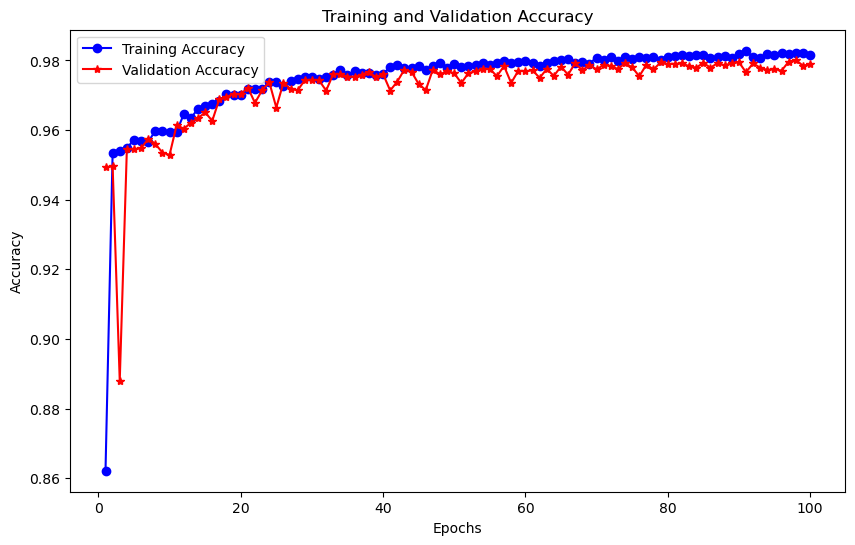

In [ ]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Extract number of epochs
epochs = range(1, len(train_acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')

# Adding titles and labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.show()


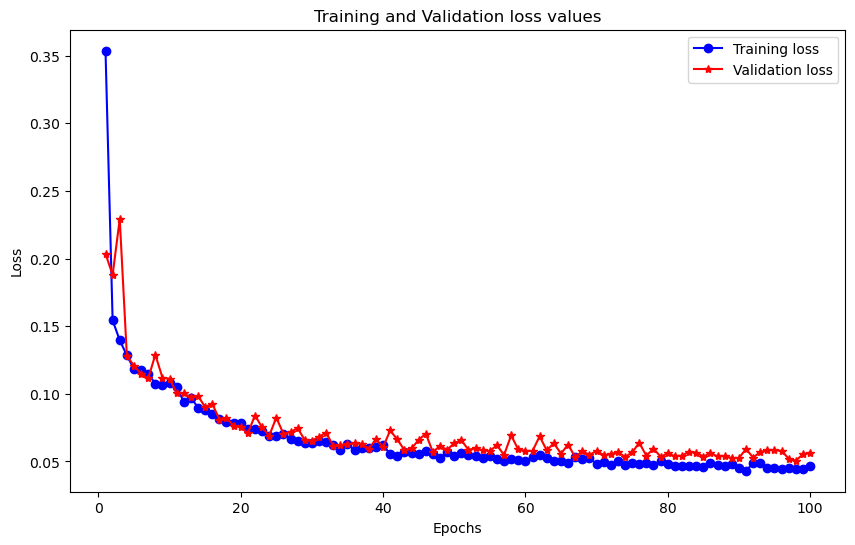

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is the variable that stores the training history returned by model.fit
# For example: history = model.fit(...)

# Extract accuracy values from the history object
train_acc = history.history['loss']
val_acc = history.history['val_loss']

# Extract number of epochs
epochs = range(1, len(train_acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, 'bo-', label='Training loss')
plt.plot(epochs, val_acc, 'r*-', label='Validation loss')

# Adding titles and labels
plt.title('Training and Validation loss values')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()
